In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
86/86 [==============================] - 41s 412ms/step - loss: 1.4252 - accuracy: 0.4757 - val_loss: 10.2744 - val_accuracy: 0.3319
Epoch 2/20
86/86 [==============================] - 32s 376ms/step - loss: 1.1397 - accuracy: 0.5923 - val_loss: 5.0021 - val_accuracy: 0.4315
Epoch 3/20
86/86 [==============================] - 32s 375ms/step - loss: 1.0497 - accuracy: 0.6175 - val_loss: 11.3791 - val_accuracy: 0.3420
Epoch 4/20
86/86 [==============================] - 32s 371ms/step - loss: 1.0071 - accuracy: 0.6361 - val_loss: 3.2788 - val_accuracy: 0.4704
Epoch 5/20
86/86 [==============================] - 32s 369ms/step - loss: 0.9886 - accuracy: 0.6438 - val_loss: 12.9709 - val_accuracy: 0.4084
Epoch 6/20
86/86 [==============================] - 32s 373ms/step - loss: 0.9192 - accuracy: 0.6555 - val_loss: 4.3906 - val_accuracy: 0.6306
Epoch 7/20
86/86 [==============================] - 33s 378ms/step - loss:

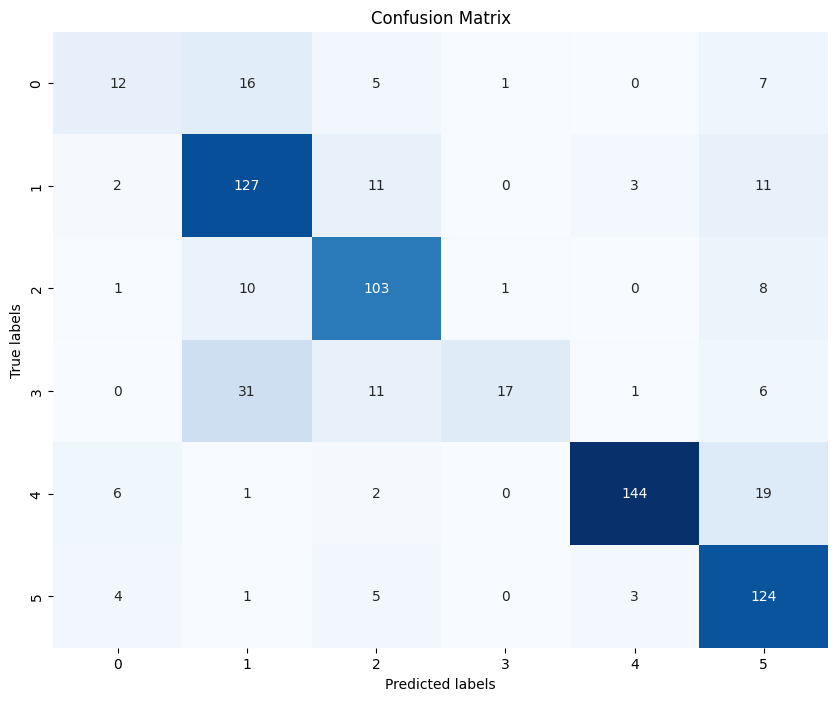

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /kaggle/working/fine_tuned_model_VGG16.h5


In [2]:
import os
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras import Model
from keras.applications import VGG16
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import *
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pathlib

SEED = 999

def build_network(base_model, classes):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=256)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes)(x)
    output = Softmax()(x)
    return output

def load_images_and_labels(image_paths, target_size=(224, 224)):  
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

def plot_learning_curve(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

def main():
    dataset_path = pathlib.Path("/kaggle/input/datasett")
    files_pattern = (dataset_path / 'Data' / '*' / '*.png')
    image_paths = [*glob(str(files_pattern))]
    CLASSES = {p.split(os.path.sep)[-2] for p in image_paths}

    X, y = load_images_and_labels(image_paths, target_size=(224, 224))
    X = X.astype('float') / 255.0
    y = LabelBinarizer().fit_transform(y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=SEED)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = build_network(base_model, len(CLASSES))
    model = Model(base_model.input, model)

    BATCH_SIZE = 32
    augmenter = ImageDataGenerator(rotation_range=60, horizontal_flip=True, width_shift_range=0.1,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
    train_generator = augmenter.flow(X_train, y_train, BATCH_SIZE)

    EPOCHS = 20
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=["accuracy"])

    model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    plot_learning_curve(history)
    print(f'Test accuracy: {result[1]}')

    for layer in base_model.layers[15:]:
        layer.trainable = True

    EPOCHS = 50
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')
    
    # Predict the classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Define class names (replace with your actual class names)
    class_names = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

    # Print classification report with class names
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save the model
    model_save_path = '/kaggle/working/fine_tuned_model_VGG16.h5'
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")
    return history
    
if __name__ == '__main__':
    history = main()


Epoch 1/20
86/86 [==============================] - 35s 383ms/step - loss: 3.6407 - accuracy: 0.4932 - val_loss: 8.9311 - val_accuracy: 0.2554
Epoch 2/20
86/86 [==============================] - 32s 366ms/step - loss: 2.3932 - accuracy: 0.5729 - val_loss: 3.6918 - val_accuracy: 0.5426
Epoch 3/20
86/86 [==============================] - 32s 375ms/step - loss: 1.9133 - accuracy: 0.6178 - val_loss: 5.9754 - val_accuracy: 0.2035
Epoch 4/20
86/86 [==============================] - 32s 377ms/step - loss: 1.6581 - accuracy: 0.6284 - val_loss: 4.5707 - val_accuracy: 0.5714
Epoch 5/20
86/86 [==============================] - 32s 373ms/step - loss: 1.5157 - accuracy: 0.6328 - val_loss: 10.3065 - val_accuracy: 0.4199
Epoch 6/20
86/86 [==============================] - 32s 375ms/step - loss: 1.3735 - accuracy: 0.6471 - val_loss: 8.9803 - val_accuracy: 0.5166
Epoch 7/20
86/86 [==============================] - 32s 372ms/step - loss: 1.2824 - accuracy: 0.6522 - val_loss: 14.4004 - val_accuracy: 0.51

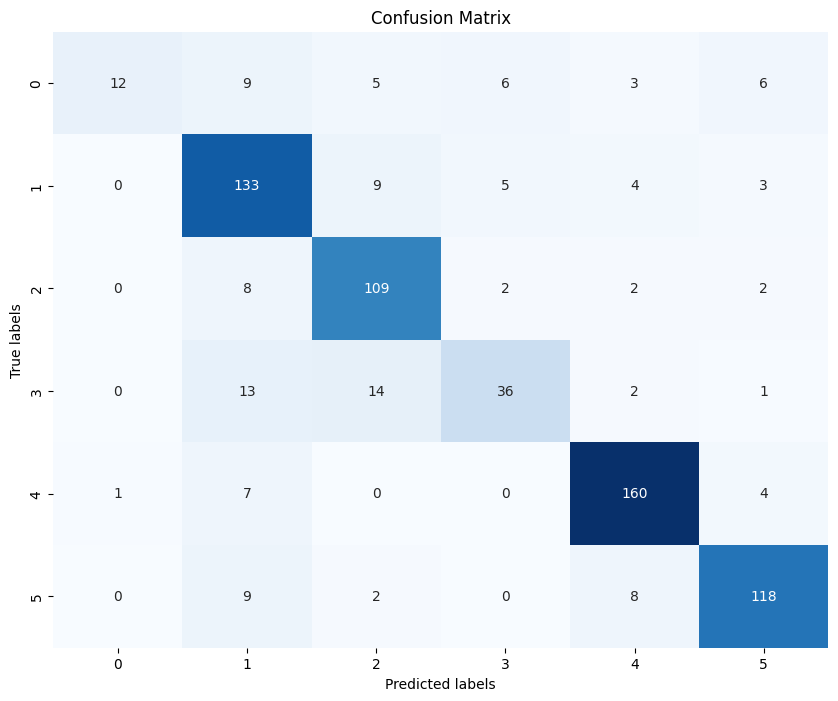

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and weights saved to: /kaggle/working/fine_tuned_model_VGG16.h5, /kaggle/working/fine_tuned_model_VGG16_weights.h5


In [3]:
import os
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Model
from keras.applications import VGG16
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import *
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pathlib

SEED = 999

def build_network(base_model, classes):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=256, kernel_regularizer='l2')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes, kernel_regularizer='l2')(x)
    output = Softmax()(x)
    return output

def load_images_and_labels(image_paths, target_size=(224, 224)):  
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

def main():
    dataset_path = pathlib.Path("/kaggle/input/datasett")
    files_pattern = (dataset_path / 'Data' / '*' / '*.png')
    image_paths = [*glob(str(files_pattern))]
    CLASSES = {p.split(os.path.sep)[-2] for p in image_paths}

    X, y = load_images_and_labels(image_paths, target_size=(224, 224))
    X = X.astype('float') / 255.0
    y = LabelBinarizer().fit_transform(y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=SEED)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = build_network(base_model, len(CLASSES))
    model = Model(base_model.input, model)

    BATCH_SIZE = 32
    augmenter = ImageDataGenerator(rotation_range=60, horizontal_flip=True, width_shift_range=0.1,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
    train_generator = augmenter.flow(X_train, y_train, BATCH_SIZE)

    EPOCHS = 20
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=["accuracy"])

    model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')

    for layer in base_model.layers[15:]:
        layer.trainable = True

    EPOCHS = 50
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')
    
    # Predict the classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Define class names (replace with your actual class names)
    class_names = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

    # Print classification report with class names
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save the entire model
    model_save_path = '/kaggle/working/fine_tuned_model_VGG16.h5'
    model.save(model_save_path)

    # Save the model weights
    weights_save_path = '/kaggle/working/fine_tuned_model_VGG16_weights.h5'
    model.save_weights(weights_save_path)

    print(f"Model and weights saved to: {model_save_path}, {weights_save_path}")
    return history
    
if __name__ == '__main__':
    history = main()
